# Setting up Hyperparameters

In [1]:
epochs = 20
negative_mining = False
soft_labels = False
nb_augment = 1
load_data_on_GPU = False

In [2]:
batch_size = 2
learning_rate = 1e-4

### Selecting the correct device for training (CPU or GPU)

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Importing the Data

In [4]:
from dataset import POCDataReader, data_augment_

data_reader = POCDataReader(root_dir="../data/POC", load_on_gpu=False, limit=None, verbose=True)

train_data, val_data, test_data = data_reader.split([0.7, 0.1, 0.2])

data_augment_(train_data, n=nb_augment, load_on_gpu=False, verbose=True)

Loading dataset into RAM:   0%|          | 0/2744 [00:00<?, ?it/s]

	- Loading done, RAM used: 11.63GiB / free: 16.03GiB / total: 62.73GiB
	- Got a total of 2744 images.


Expending the dataset 1 more times:   0%|          | 0/1920 [00:00<?, ?it/s]

	- Augmentation done, RAM used: 14.36GiB / free: 13.30GiB / total: 62.73GiB
	- Got 1920 new images and a total of 3840 images.


In [5]:
from torch.nn import Sequential
from torchvision.transforms.functional import invert
from torch.nn.functional import normalize

from pipelines import InputPipeline, SumFilters
from pipelines.filters import *


sumFilter = SumFilters(FrangiFilter(), SatoFilter())
crackBinFilter = Sequential(FrangiFilter(), CrackBinaryFilter(0.75))
bgBinFilter = Sequential(FrangiFilter(), BGBinaryFilter(60.))
skeletonFilter = SkeletonFilter(crackBinFilter)
watershedFilter = WatershedFilter(background_filter=bgBinFilter, foreground_filter=skeletonFilter)

inpip = InputPipeline(
    transformer=None,
    layer_transformer=[
        LaplacianFilter(),
#         FrangiFilter(),
#         SatoFilter(),
#         sumFilter,
#         crackBinFilter,
#         bgBinFilter,
#         skeletonFilter,
#         watershedFilter,
   ]
)

# inpip = inpip.to(device)

### Creating Training Dataset

In [6]:
from torch.nn.functional import normalize
from torchvision.transforms import CenterCrop, Resize, GaussianBlur

from dataset import POCDataset

train_dataset = POCDataset(
    train_data,
    transform=Sequential(inpip, CenterCrop(size=(480, 480)), Resize(size=(384, 384))),
    target_transform=Sequential(CenterCrop(size=(480, 480)), Resize(size=(384, 384))),
    negative_mining=negative_mining,
    load_on_gpu=load_data_on_GPU,
    verbose=True
)

train_dataset.precompute_transform(verbose=True)

	- Loading done, RAM used: 18.77GiB / free: 8.88GiB / total: 62.73GiB


Applying transform to the Dataset:   0%|          | 0/3840 [00:00<?, ?it/s]

	- Transformation done, RAM used: 18.79GiB / free: 8.92GiB / total: 62.73GiB


In [7]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.sampler,
        shuffle= True if train_dataset.sampler is None else None,
    )
else:
    training_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_dataset.sampler,
        shuffle= True if train_dataset.sampler is None else None,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Creating Validation Dataset

In [8]:
from dataset import POCDataset

val_dataset = POCDataset(val_data, transform=Sequential(inpip, CenterCrop(size=(480, 480)), Resize(size=(384, 384))), target_transform=Sequential(CenterCrop(size=(480, 480)), Resize(size=(384, 384))), negative_mining=False)

In [9]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size= 2 * batch_size,
        shuffle=True,
    )
else:
    validation_dataloader = DataLoader(
        val_dataset,
        batch_size= 2 * batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Creating Evaluation Dataset

In [10]:
from dataset import POCDataset

test_dataset = POCDataset(test_data, transform=Sequential(inpip, CenterCrop(size=(480, 480)), Resize(size=(384, 384))), target_transform=Sequential(CenterCrop(size=(480, 480)), Resize(size=(384, 384))), negative_mining=False)

In [11]:
from torch.utils.data import DataLoader

if load_data_on_GPU:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
    )
else:
    evaluation_dataloader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
        pin_memory_device=device,
    )

### Testing the dataloader

torch.Size([2, 4, 384, 384]) torch.Size([2, 2, 384, 384])
['soo_seg299.png', 'DY_175.png'] tensor([1460, 1142])


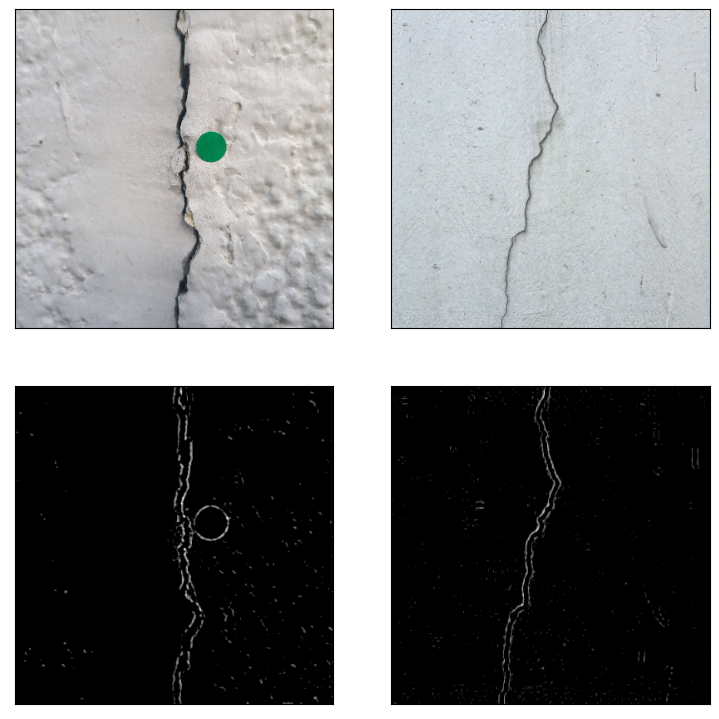

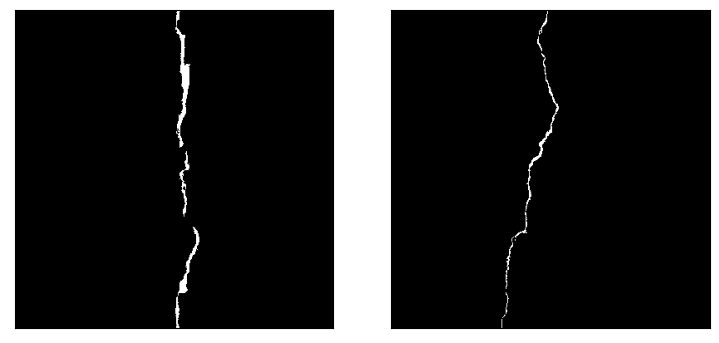

In [12]:
from my_utils import show_img

features, masks, files, indexes = next(iter(training_dataloader))
print(features.size(), masks.size())

show_img(features)
show_img(masks)
print(files, indexes)

### Testing Dataset for proportion between classes

In [13]:
_,train_labels,_,_ = next(iter(training_dataloader))

nb_pixel = torch.unique(train_labels, return_counts=True)[1]
print("Proportion of class 1 in this batch: {}%".format(nb_pixel[1] * 100 / (nb_pixel[0] + nb_pixel[1])))

Proportion of class 1 in this batch: 0.009547125548124313%


Result is usually around 1.1% which may be too low for cross_entropy_loss.

# Building the differents modules

## Creating the models

#### Using Unet with bilinear upsampling and cropping to generate 2 classes (background and crack).

In [14]:
from models import UNet, DeepCrack, SubUNet, DenSubUNet

# model = UNet(n_channels=1, n_classes=2, bilinear=True, crop=False).to(device)
# model = DeepCrack(n_channels=inpip.nb_channel, n_classes=2).to(device)
# model = SubUNet(n_channels=inpip.nb_channel, n_classes=2).to(device)
model = DenSubUNet(n_channels=inpip.nb_channel, n_classes=2).to(device)

In [15]:
print("Total number of parameters: {0:,}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
print(f"Model structure: {model}")

Total number of parameters: 16,840,818
Model structure: DenSubUNet


## Creating the loss functions

#### Cross Entropy Loss

In [ ]:
import torch
from torch.nn import CrossEntropyLoss

weight = torch.tensor([.9, .1])  # class weight : 98% for background and 2% for the cracks
loss_fn = CrossEntropyLoss(weight=weight).to(device)

#### Dice Loss

In [ ]:
from loss import DiceLoss

loss_fn = DiceLoss().to(device)

#### Focal Loss

In [ ]:
import torch
from loss import FocalLoss

weight = torch.tensor([.9, .1])  # class weight : 90% for background and 10% for the cracks
loss_fn = FocalLoss(weight=weight, gamma=2).to(device)

#### Jaccard Loss

In [ ]:
from loss import JaccardLoss

loss_fn = JaccardLoss().to(device)

#### Tversky Loss

In [ ]:
import torch
from loss import TverskyLoss

loss_fn = TverskyLoss(alpha=0.3, beta=0.7).to(device)

#### Focal Tversky Loss

In [ ]:
import torch
from loss import FocalTverskyLoss

loss_fn = FocalTverskyLoss(alpha=0.3, beta=0.7, gamma=2).to(device)

#### Combined (Focal + Tversky) Loss

In [ ]:
import torch
from loss import CombinedLoss, TverskyLoss, FocalLoss

weight = torch.tensor([.3, .7])

loss_fn = CombinedLoss(
    FocalLoss(weight=weight, gamma=2),
    TverskyLoss(alpha=0.3, beta=0.7),
    ratio=0.75).to(device)

#### Bordered (Focal + Tversky) Loss

In [16]:
import torch
from loss import BorderedLoss, JaccardLoss, FocalLoss

weight = torch.tensor([.5, .5])

loss_fn = BorderedLoss(
    border_loss=FocalLoss(weight=weight, gamma=2),
    volume_loss=JaccardLoss(),
    ratio=0.7).to(device)

In [ ]:
from loss import MultiscaleLoss

loss_fn = MultiscaleLoss(loss_fn)

## Creating the Optimizer

In [17]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99))

## Setting up the Learning Rate Scheduler

In [18]:
from torch.optim.lr_scheduler import CosineAnnealingLR

lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

## Creating the Metrics

In [19]:
from metrics import Metrics, EvaluationMetrics


train_metrics = Metrics(
    buffer_size=len(training_dataloader),
    mode="Training",
    hyperparam={
        "Network": model.__class__,
        "Optimizer": optimizer.__class__,

        "Learning Rate": learning_rate,
        "Batch Size": batch_size,

        "Loss Combiner": BorderedLoss,
        "Loss Combiner_ratio": 0.7,
        "Loss Volume": JaccardLoss,
        "Loss Pixel": FocalLoss,
        "Loss Pixel_gamma": 2,
        "Loss Pixel_weight": .5,

        "Negative Mining": negative_mining,
        "Smooth Labeling": soft_labels,

        "Pipe Filter": normalize,
        "Pipe Layer": LaplacianFilter,
        "Pipe Layer_threshold": 0.75,
    },
    device=device)

val_metrics = Metrics(
    buffer_size=len(validation_dataloader),
    mode="Validation",
    hyperparam={
        "Network": model.__class__,
        "Optimizer": optimizer.__class__,

        "Learning Rate": learning_rate,
        "Batch Size": batch_size,

        "Loss Combiner": BorderedLoss,
        "Loss Combiner_ratio": 0.7,
        "Loss Volume": JaccardLoss,
        "Loss Pixel": FocalLoss,
        "Loss Pixel_gamma": 2,
        "Loss Pixel_weight": .5,

        "Negative Mining": negative_mining,
        "Smooth Labeling": soft_labels,

        "Pipe Filter": normalize,
        "Pipe Layer": LaplacianFilter,
        "Pipe Layer_threshold": 0.75,
    },
    device=device)

test_metrics = EvaluationMetrics(
    buffer_size=len(evaluation_dataloader),
    hyperparam={
        "Network": model.__class__,
        "Optimizer": optimizer.__class__,

        "Learning Rate": learning_rate,
        "Batch Size": batch_size,

        "Loss Combiner": BorderedLoss,
        "Loss Combiner_ratio": 0.7,
        "Loss Volume": JaccardLoss,
        "Loss Pixel": FocalLoss,
        "Loss Pixel_gamma": 2,
        "Loss Pixel_weight": .5,

        "Negative Mining": negative_mining,
        "Smooth Labeling": soft_labels,

        "Pipe Filter": normalize,
        "Pipe Layer": LaplacianFilter,
        "Pipe Layer_threshold": 0.75,
    },
    epochs=epochs,
    device=device)

# Training, testing and validating the Model

In [20]:
from torch import autograd

from train_tqdm import training_loop, validation_loop, evaluation_loop

autograd.set_detect_anomaly(True)

for epoch in range(1, epochs+1):
    training_loop(epoch, training_dataloader, model, loss_fn, optimizer, lr_scheduler, train_metrics, device)
    validation_loop(epoch, validation_dataloader, model, loss_fn, val_metrics, device)

evaluation_loop(evaluation_dataloader, model, test_metrics, device)

train_metrics.close_tensorboard()
val_metrics.close_tensorboard()
test_metrics.close_tensorboard()

[Training] Epoch: 1 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 1 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 2 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 2 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 3 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 3 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 4 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 4 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 5 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 5 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 6 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 6 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 7 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 7 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 8 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 8 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 9 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 9 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 10 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 10 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 11 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 11 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 12 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 12 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 13 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 13 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 14 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 14 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 15 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 15 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 16 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 16 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 17 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 17 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 18 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 18 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 19 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 19 :   0%|          | 0/69 [00:00<?, ?it/s]

[Training] Epoch: 20 :   0%|          | 0/1920 [00:00<?, ?it/s]

[Validating] Epoch: 20 :   0%|          | 0/69 [00:00<?, ?it/s]

[Evaluating]:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
from my_utils import show_img

features, masks, files, _ = next(iter(training_dataloader))
print(features.size(), masks.size())

show_img(features)
show_img(masks)
print(files)

In [ ]:
from torchvision.transforms.functional import rgb_to_grayscale

image1 = features[1,0:3]   # (3, 480, 640)
image1 = rgb_to_grayscale(image1)   #(1, 480, 640)
skel1 = features[1,3]   #(480, 640)

In [ ]:
numpy_img = image1.squeeze(0).cpu().numpy()
numpy_skel = skel1.cpu().numpy()

In [ ]:
import numpy as np

pts_list = np.nonzero(numpy_skel)

In [ ]:
from skimage.segmentation import flood

flood_mask = np.zeros_like(numpy_img, dtype=bool)
for x,y in zip(pts_list[0], pts_list[1]):
    flood_mask = flood_mask | flood(image=numpy_img, seed_point=(x,y), connectivity=200, tolerance=0.1)

In [ ]:
import torch

flood_tensor = torch.from_numpy(flood_mask).float().unsqueeze(0).unsqueeze(0)

In [ ]:
flood_tensor.unique(return_counts=True)

In [ ]:
show_img(flood_tensor)